# Data Science Salary Prediction


1. 목표 : 데이터  사이언스 직종과 관련된 컬럼 별 인사이트 도출 및 급여 예측 모델 구축
2. 결과 : 급여 예측 모델, 시각화 이미지 및 분석 인사이트 + 추가 예정
3. 데이터 수집 출처

https://www.kaggle.com/datasets/fahadrehman07/data-science-jobs-and-salary-glassdoor/data

glassdoor_jobs.csv,Glassdoor_Salary_Cleaned_Version.csv

4. 수행 계획
- 환경 설정 및 데이터 불러오기
- 데이터 전처리 spark, sql
 - Salary,Company
 - 컬럼 추가
      -사용 가능 언어
- 데이터 탐색 EDA 
 - sns,plt
- 모델 예측

# 1. 환경설정 및 데이터 불러오기

In [1]:
from pyspark.sql.functions import *
from pyspark.sql import SparkSession

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName("241212_01_DS-JOBS&SALARY").getOrCreate()

24/12/20 16:17:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
jobs_df = spark.read.format('csv')\
    .option('header', 'true')\
    .option('inferSchema', 'true')\
    .option('multiLine', 'true')\
    .option('escpae', '')\
    .load('data/glassdoor_jobs.csv')

## 1.1 데이터 구조 확인

jobs_df.printSchema()
jobs_df.createOrReplaceTempView("jobs_df")

print(jobs_df.count())

In [81]:
jobs_df.show(3)

+---+--------------------+---------------+--------------------+------+--------------------+---------------+--------------+--------------------+-------+------------------+--------------------+-------------------+--------------------+-----------+----------+----------+----------+------+--------+-----+---+-----+------+--------------+---------+
|_c0|           Job Title|Salary Estimate|     Job Description|Rating|        Company Name|       Location|  Headquarters|                Size|Founded| Type of ownership|            Industry|             Sector|             Revenue|Competitors|Min_Salary|Max_Salary|Avg_Salary|Python|R Studio|Spark|AWS|Excel|ComAge|      Simp_Job|Job_Level|
+---+--------------------+---------------+--------------------+------+--------------------+---------------+--------------+--------------------+-------+------------------+--------------------+-------------------+--------------------+-----------+----------+----------+----------+------+--------+-----+---+-----+------+

24/12/20 16:51:19 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Job Title, Salary Estimate, Job Description, Rating, Company Name, Location, Headquarters, Size, Founded, Type of ownership, Industry, Sector, Revenue, Competitors
 Schema: _c0, Job Title, Salary Estimate, Job Description, Rating, Company Name, Location, Headquarters, Size, Founded, Type of ownership, Industry, Sector, Revenue, Competitors
Expected: _c0 but found: 
CSV file: file:///home/lab15/src/data/glassdoor_jobs.csv


## 1.2 column 설명

1. Job Title : 직업명 
2. Salary Estimate : 예상 급여 
3. Job Description : 직무 설명
4. Rating : 평점
5. Company Name : 회사명
6. Location : 회사위치
7. Headquarters : 본사
8. Size : 회사사원수 
9. Founded : 회사설립년도 
10. Type of ownership : 운영 형태 ex) 민간, 공공, 정부 및 비영리 단체
11. Sector : 산업 분야 ex) Energy, Oil, Gas
12. Revenue : 회사 총 수익 
13. Competitors : 경쟁 기업

In [5]:
jobs_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 _c0|           Job Title|     Salary Estimate|     Job Description|              Rating|        Company Name|       Location|     Headquarters|                Size|             Founded|   Type of ownership|            Industry|              Sector|             Revenue|         Competitors|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                   0|      Data Scientist|$53K-$91K (Glassd...|Data Scie

24/12/20 16:17:10 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Job Title, Salary Estimate, Job Description, Rating, Company Name, Location, Headquarters, Size, Founded, Type of ownership, Industry, Sector, Revenue, Competitors
 Schema: _c0, Job Title, Salary Estimate, Job Description, Rating, Company Name, Location, Headquarters, Size, Founded, Type of ownership, Industry, Sector, Revenue, Competitors
Expected: _c0 but found: 
CSV file: file:///home/lab15/src/data/glassdoor_jobs.csv


In [6]:
# 보기용 pandas
df = pd.read_csv("data/glassdoor_jobs.csv")
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa..."
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"


In [7]:
df['Job Title'].value_counts().head(20)

Job Title
Data Scientist                                            178
Data Engineer                                              68
Senior Data Scientist                                      42
Data Analyst                                               18
Senior Data Engineer                                       17
Business Intelligence Analyst                              13
Senior Data Analyst                                        12
Lead Data Scientist                                         8
Data Science Manager                                        7
Principal Data Scientist                                    6
Machine Learning Engineer                                   6
Marketing Data Analyst                                      6
Sr. Data Engineer                                           6
Analytics Manager                                           5
Lead Data Engineer                                          5
Data Engineer 5 - Contract                                  

# 2. 데이터 전처리



## 2.1 정리 할 컬럼

1. Salary Estimate - $k (Glassdoor est.) 포함한 모든 텍스트, null 값
2. Company Name - split \n

In [8]:
jobs_df.select('Salary Estimate').show(30, truncate=False)

+-----------------------------------------------------------------------+
|Salary Estimate                                                        |
+-----------------------------------------------------------------------+
|$53K-$91K (Glassdoor est.)                                             |
|$63K-$112K (Glassdoor est.)                                            |
|$80K-$90K (Glassdoor est.)                                             |
|$56K-$97K (Glassdoor est.)                                             |
|$86K-$143K (Glassdoor est.)                                            |
|$71K-$119K (Glassdoor est.)                                            |
|$54K-$93K (Glassdoor est.)                                             |
|$86K-$142K (Glassdoor est.)                                            |
|$38K-$84K (Glassdoor est.)                                             |
|$120K-$160K (Glassdoor est.)                                           |
|$126K-$201K (Glassdoor est.)         

In [9]:
# 1. Salary Estimate - $k (Glassdoor est.) 포함한 모든 텍스트, null 값

import re
#null 값 지우기
jobs_df = jobs_df.filter(jobs_df["Salary Estimate"].isNotNull())

# '(Glassdoor est.)' 제거, 'K' 제거, '$' 제거 - 숫자 범위만 남기기
jobs_df = jobs_df.withColumn(
    "Salary Estimate",
    regexp_replace(
        regexp_extract(col("Salary Estimate"), r'\$(\d+)K?-\$(\d+)K?', 0),
        r"[$K]", ""
    )
)

# 공백 제거 후 비어있는 행 제거
jobs_df = jobs_df.withColumn("Salary Estimate", trim(col("Salary Estimate")))
jobs_df = jobs_df.filter(col("Salary Estimate") != "")

jobs_df.select('Salary Estimate').show(truncate=False)

+---------------+
|Salary Estimate|
+---------------+
|53-91          |
|63-112         |
|80-90          |
|56-97          |
|86-143         |
|71-119         |
|54-93          |
|86-142         |
|38-84          |
|120-160        |
|126-201        |
|64-106         |
|106-172        |
|46-85          |
|83-144         |
|102-190        |
|67-137         |
|118-189        |
|110-175        |
|64-111         |
+---------------+
only showing top 20 rows



In [82]:
# 2. Company Name - split \

jobs_df = jobs_df.withColumn('Company Name', split(col('Company Name'), '\n').getItem(0))

jobs_df.select('Company Name').show(truncate=False)

+-------------------------------------+
|Company Name                         |
+-------------------------------------+
|Tecolote Research                    |
|University of Maryland Medical System|
|KnowBe4                              |
|PNNL                                 |
|Affinity Solutions                   |
|CyrusOne                             |
|ClearOne Advantage                   |
|Logic20/20                           |
|Rochester Regional Health            |
|<intent>                             |
|Wish                                 |
|ManTech                              |
|Walmart                              |
|Yesler                               |
|Takeda Pharmaceuticals               |
|Audible                              |
|Blueprint Medicines                  |
| IBM                                 |
|Nuna                                 |
|Pinnacol Assurance                   |
+-------------------------------------+
only showing top 20 rows



##  2.2.1 컬럼 추가 - Salary

1. Min_Salary
2. Max_Salary
3. Avg_Salary

In [11]:
# 1. Min_Salary
jobs_df = jobs_df.withColumn('Min_Salary', split(col('Salary Estimate'), '-').getItem(0))

# 2. Max_Salary
jobs_df = jobs_df.withColumn('Max_Salary', split(col('Salary Estimate'), '-').getItem(1))

# 3. Avg_Salary
jobs_df = jobs_df.withColumn('Avg_Salary', (col('Min_Salary') + col('Max_Salary')) / 2)

jobs_df.select("Min_Salary", "Max_Salary", "Avg_Salary").show(5)


+----------+----------+----------+
|Min_Salary|Max_Salary|Avg_Salary|
+----------+----------+----------+
|        53|        91|      72.0|
|        63|       112|      87.5|
|        80|        90|      85.0|
|        56|        97|      76.5|
|        86|       143|     114.5|
+----------+----------+----------+
only showing top 5 rows



## 2.2.2  컬럼 추가 - 사용언어

In [12]:
jobs_df.select("Job Description").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
jobs_df = jobs_df.withColumn('Python', 
                   when(lower(col('Job Description')).contains('python'), 1).otherwise(0))

jobs_df = jobs_df.withColumn('R Studio', 
                   when(lower(col('Job Description')).rlike('r-studio|r_studio|r studio'), 1).otherwise(0))

jobs_df = jobs_df.withColumn('Spark', 
                   when(lower(col('Job Description')).contains('spark'), 1).otherwise(0))

jobs_df = jobs_df.withColumn('AWS', 
                   when(lower(col('Job Description')).contains('aws'), 1).otherwise(0))

jobs_df = jobs_df.withColumn('Excel', 
                   when(lower(col('Job Description')).contains('excel'), 1).otherwise(0))

jobs_df.select("Python", "R Studio", "Spark", "AWS", "Excel").show(5)

+------+--------+-----+---+-----+
|Python|R Studio|Spark|AWS|Excel|
+------+--------+-----+---+-----+
|     1|       0|    0|  0|    1|
|     1|       0|    0|  0|    0|
|     1|       0|    1|  0|    1|
|     1|       0|    0|  0|    0|
|     1|       0|    0|  0|    1|
+------+--------+-----+---+-----+
only showing top 5 rows



In [14]:
jobs_df.select("Job Title").show(20, truncate=False)

+--------------------------------------+
|Job Title                             |
+--------------------------------------+
|Data Scientist                        |
|Healthcare Data Scientist             |
|Data Scientist                        |
|Data Scientist                        |
|Data Scientist                        |
|Data Scientist                        |
|Data Scientist                        |
|Data Scientist                        |
|Research Scientist                    |
|Data Scientist                        |
|Data Scientist                        |
|Data Scientist                        |
|Staff Data Scientist - Technology     |
|Data Analyst                          |
|Data Scientist                        |
|Data Engineer I                       |
|Scientist I/II, Biology               |
|Customer Data Scientist               |
|Data Scientist - Health Data Analytics|
|Data Scientist                        |
+--------------------------------------+
only showing top

In [15]:
from pyspark.sql.types import IntegerType
jobs_df = jobs_df.withColumn('Founded', col('Founded').cast(IntegerType()))
jobs_df = jobs_df.withColumn('ComAge', 2024 - col('Founded'))
jobs_df.select('ComAge').show(5)

+------+
|ComAge|
+------+
|    51|
|    40|
|    14|
|    59|
|    26|
+------+
only showing top 5 rows



##  2.2.3 UDF로 컬럼 생성

In [16]:
@udf(StringType())
def job_simplifier(title):
    if 'data scientist' in title.lower():
        return 'data scientist'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'analyst' in title.lower():
        return 'analyst'
    elif 'machine learning' in title.lower():
        return 'mle'
    elif 'manager' in title.lower():
        return 'manager'
    elif 'director' in title.lower():
        return 'director'
    else:
        return 'na'


In [17]:
jobs_df = jobs_df.withColumn('Simp_Job', job_simplifier(col('Job Title')))
jobs_df.select("Simp_job").show(20)


+--------------+
|      Simp_job|
+--------------+
|data scientist|
|data scientist|
|data scientist|
|data scientist|
|data scientist|
|data scientist|
|data scientist|
|data scientist|
|            na|
|data scientist|
|data scientist|
|data scientist|
|data scientist|
|       analyst|
|data scientist|
| data engineer|
|            na|
|data scientist|
|data scientist|
|data scientist|
+--------------+
only showing top 20 rows



### UDF 로 Job LEVEL 체크

In [18]:
@udf(StringType())
def seniority(title):
    if 'sr' in title.lower() or 'senior' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower():
        return 'senior'
    elif 'jr' in title.lower() or 'jr.' in title.lower() or 'junior' in title.lower():
        return 'junior'
    elif 'mid_level' in title.lower() or 'medior' in title.lower() or 'intermediate' in title.lower():
        return 'medior'
    else:
        return 'na'

In [19]:
jobs_df = jobs_df.withColumn('Job_Level', seniority(col('Job Title')))
level_job_df = jobs_df.groupBy('Job_Level').agg(count('*').alias('count')).orderBy(desc('count'))

level_job_df.show()

+---------+-----+
|Job_Level|count|
+---------+-----+
|       na|  519|
|   senior|  220|
|   junior|    3|
+---------+-----+



# 3.  EDA

In [20]:
jdf = jobs_df.toPandas()

24/12/20 16:17:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/20 16:17:17 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Job Title, Salary Estimate, Job Description, Rating, Company Name, Location, Headquarters, Size, Founded, Type of ownership, Industry, Sector, Revenue, Competitors
 Schema: _c0, Job Title, Salary Estimate, Job Description, Rating, Company Name, Location, Headquarters, Size, Founded, Type of ownership, Industry, Sector, Revenue, Competitors
Expected: _c0 but found: 
CSV file: file:///home/lab15/src/data/glassdoor_jobs.csv


In [21]:
jdf.head()

,_c0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,Max_Salary,Avg_Salary,Python,R Studio,Spark,AWS,Excel,ComAge,Simp_Job,Job_Level
0,0,Data Scientist,53-91,"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973.0,...,91,72.0,1,0,0,0,1,51.0,data scientist,na
1,1,Healthcare Data Scientist,63-112,What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System,"Linthicum, MD","Baltimore, MD",10000+ employees,1984.0,...,112,87.5,1,0,0,0,0,40.0,data scientist,na
2,2,Data Scientist,80-90,"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010.0,...,90,85.0,1,0,1,0,1,14.0,data scientist,na
3,3,Data Scientist,56-97,*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL,"Richland, WA","Richland, WA",1001 to 5000 employees,1965.0,...,97,76.5,1,0,0,0,0,59.0,data scientist,na
4,4,Data Scientist,86-143,Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions,"New York, NY","New York, NY",51 to 200 employees,1998.0,...,143,114.5,1,0,0,0,1,26.0,data scientist,na


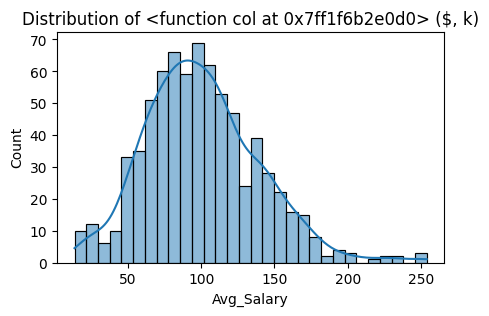

In [22]:
# 평균 급여
plt.figure(figsize=(5,3))
sns.histplot(jdf['Avg_Salary'], kde=True, bins=30)
plt.title(f'Distribution of {col} ($, k)')
plt.show()

/tmp/ipykernel_7682/3985635259.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(jdf['Min_Salary'], kde=True, bins=30)


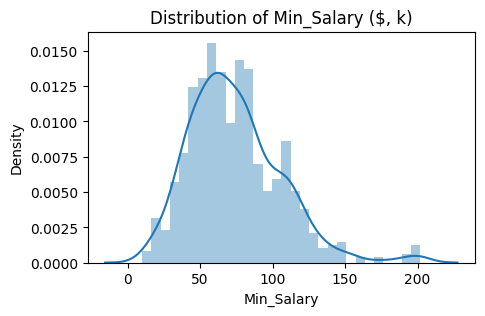

In [23]:
plt.figure(figsize=(5,3))
sns.distplot(jdf['Min_Salary'], kde=True, bins=30)
plt.title(f'Distribution of Min_Salary ($, k)')
plt.show()

/tmp/ipykernel_7682/1207847570.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(jdf['Max_Salary'], kde=True, bins=30)


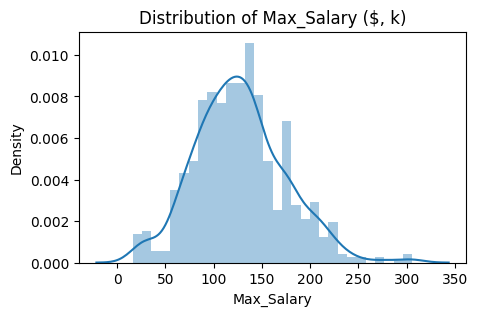

In [24]:
plt.figure(figsize=(5,3))
sns.distplot(jdf['Max_Salary'], kde=True, bins=30)
plt.title('Distribution of Max_Salary ($, k)')
plt.show()

In [25]:
df_cat = jdf[['Location','Type of ownership', 'Industry', 'Sector','Revenue', 'Company Name', 'Rating']]

/tmp/ipykernel_7682/3356610858.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=cat_num.index, x=cat_num, palette=colors, ax=axes[i])
/tmp/ipykernel_7682/3356610858.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=cat_num.index, x=cat_num, palette=colors, ax=axes[i])
/tmp/ipykernel_7682/3356610858.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=cat_num.index, x=cat_num, palette=colors, ax=axes[i])
/tmp/ipykernel_7682/3356610858.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remo

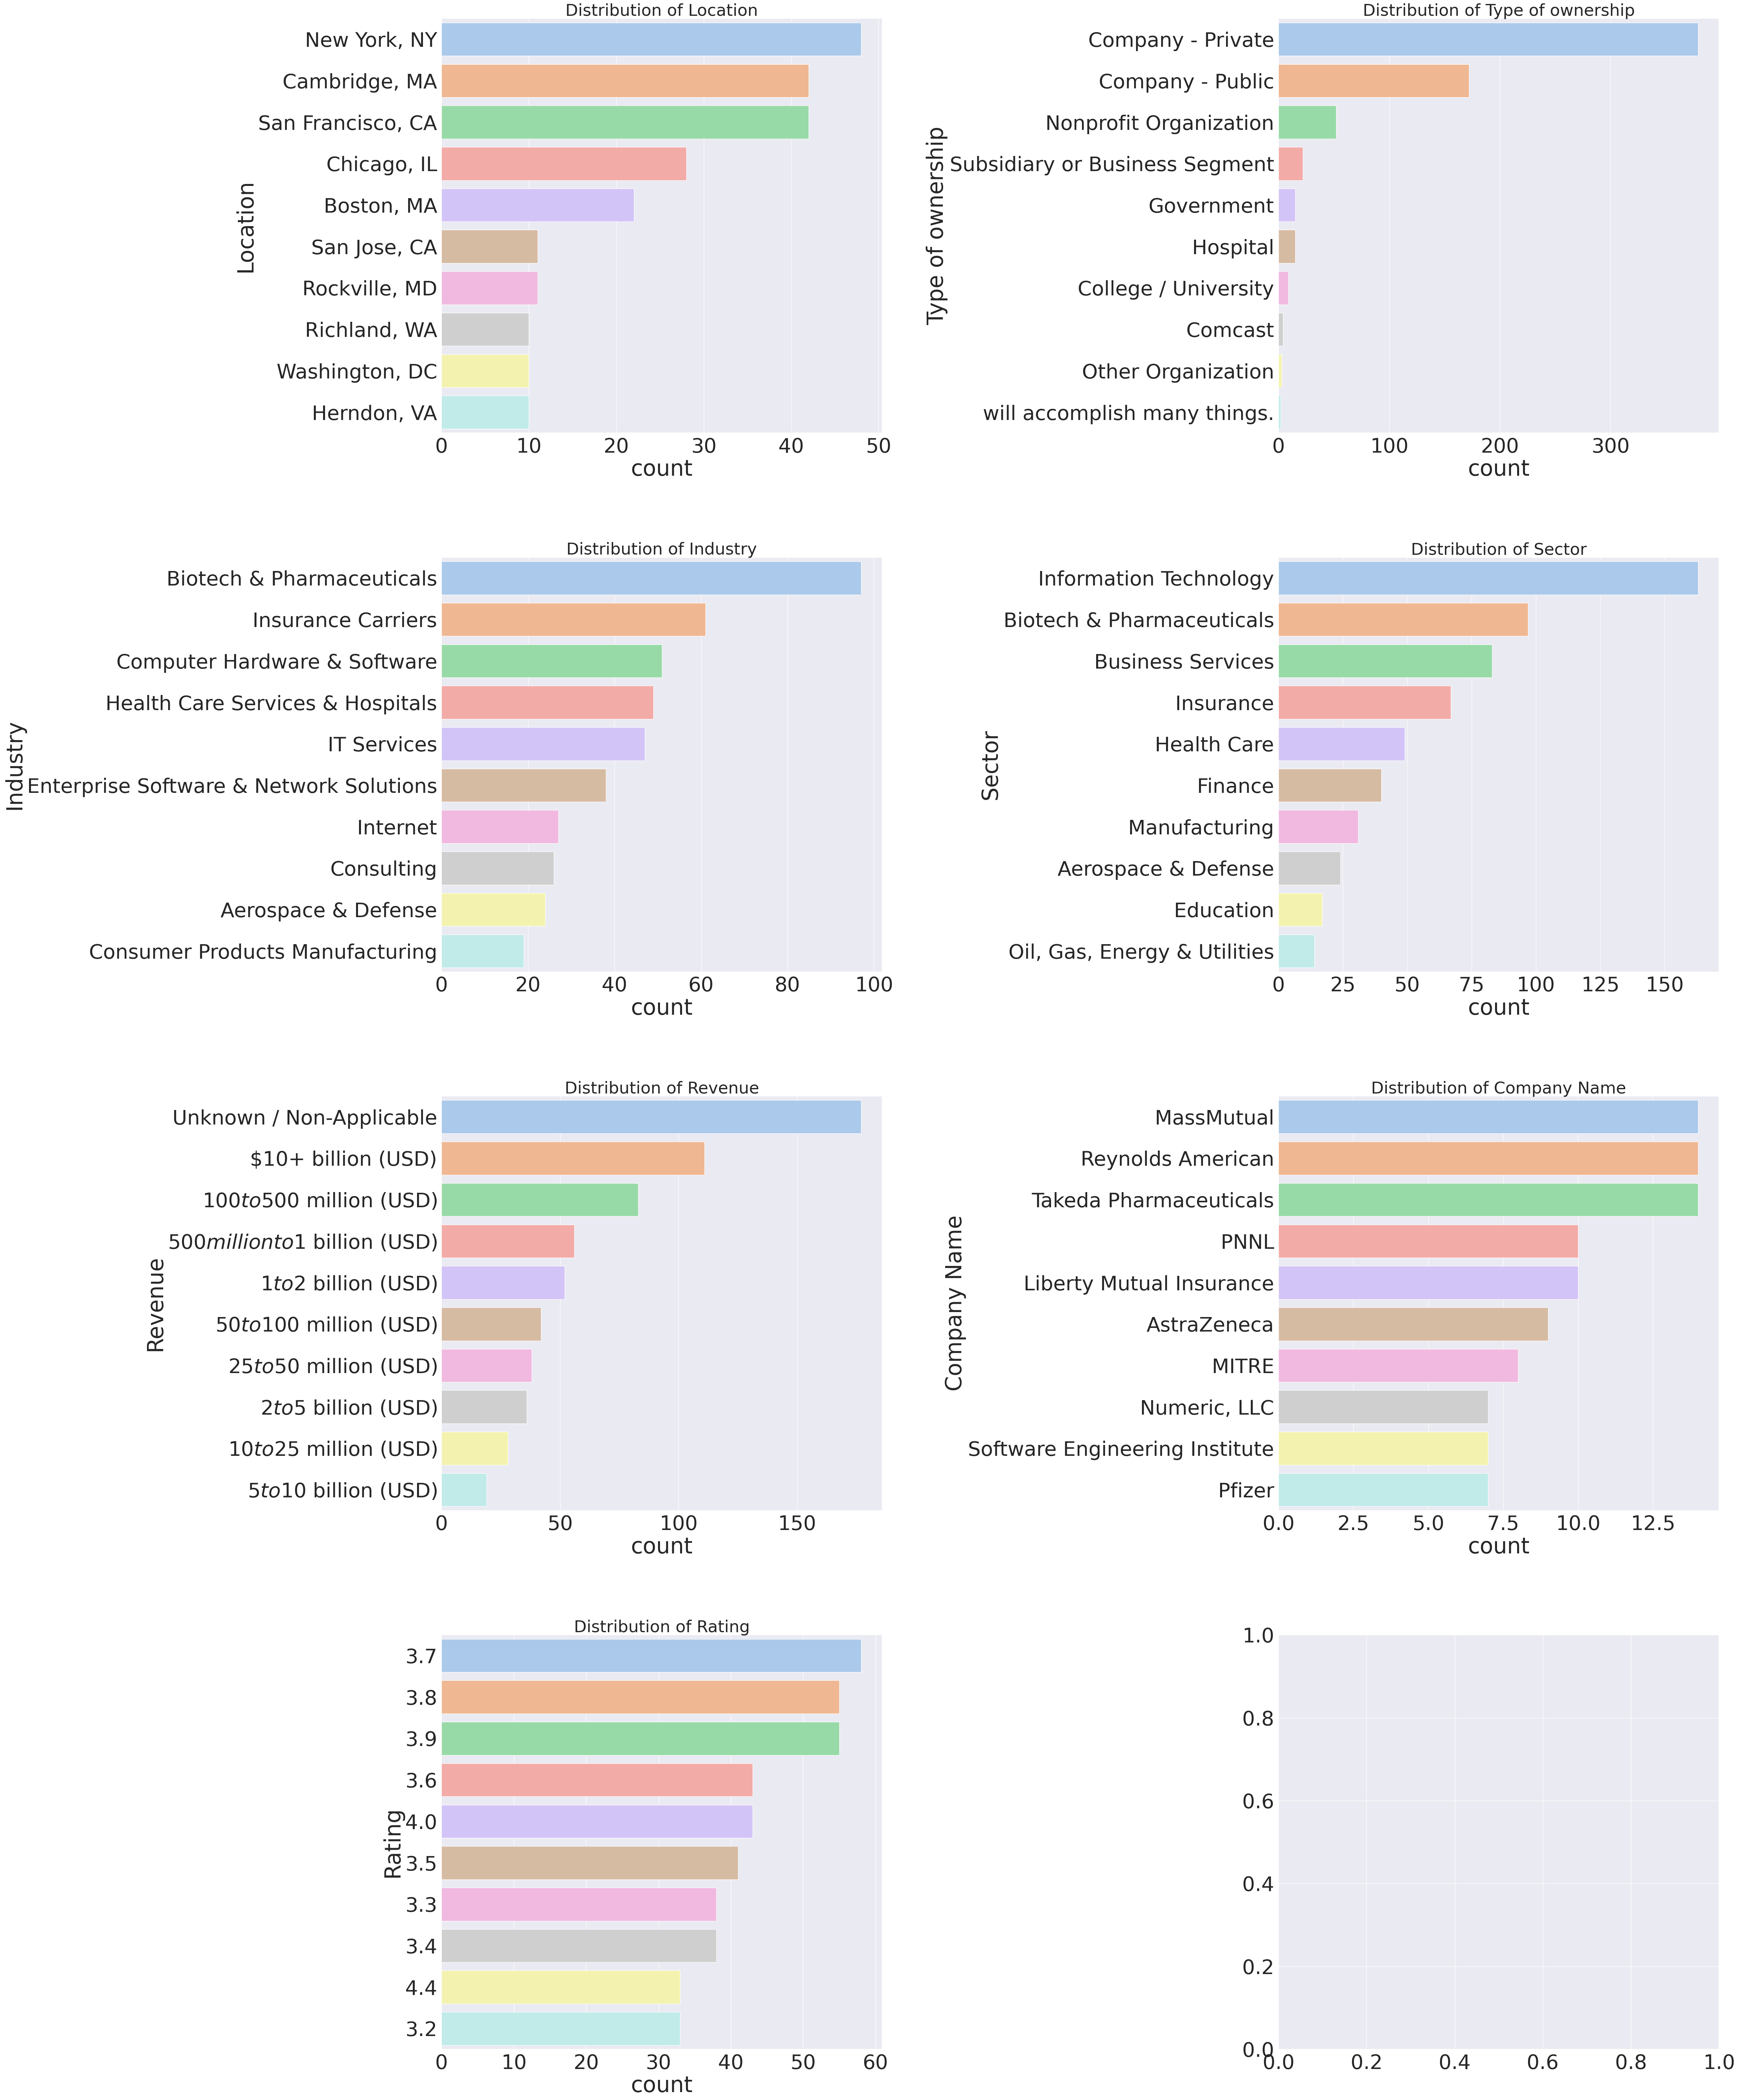

In [84]:
num_rows = len(df_cat.columns) // 2 + len(df_cat.columns) % 2

fig, axes = plt.subplots(num_rows, 2, figsize=(50, 20*num_rows))


axes = axes.flatten()

for i, col in enumerate(df_cat.columns):
    # Get value counts for the current column
    cat_num = df_cat[col].value_counts().head(10)
    
    # Generate a list of colors for each bar
    colors = sns.color_palette("pastel", len(cat_num))
    
    # Plot the bar chart with custom colors
    sns.barplot(y=cat_num.index, x=cat_num, palette=colors, ax=axes[i])
    sns.set(font_scale=3) 
    # Set title for the subplot
    axes[i].set_title(f"Distribution of {col}")
    
    # Rotate x-axis labels
    #axes[i].tick_params(axis='x', rotation=90)
    
# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=0.9, hspace=0.3)
sns.set(font_scale=4)
# Show the plots
plt.show()

In [27]:
df_cat2 = jdf[['Python','R Studio', 'Spark', 'AWS','Excel','ComAge','Simp_Job','Job_Level']]

/tmp/ipykernel_7682/4222639503.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_num2.index, y=cat_num2, palette=colors, ax=axes[i])
/tmp/ipykernel_7682/4222639503.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_num2.index, y=cat_num2, palette=colors, ax=axes[i])
/tmp/ipykernel_7682/4222639503.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_num2.index, y=cat_num2, palette=colors, ax=axes[i])
/tmp/ipykernel_7682/4222639503.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will b

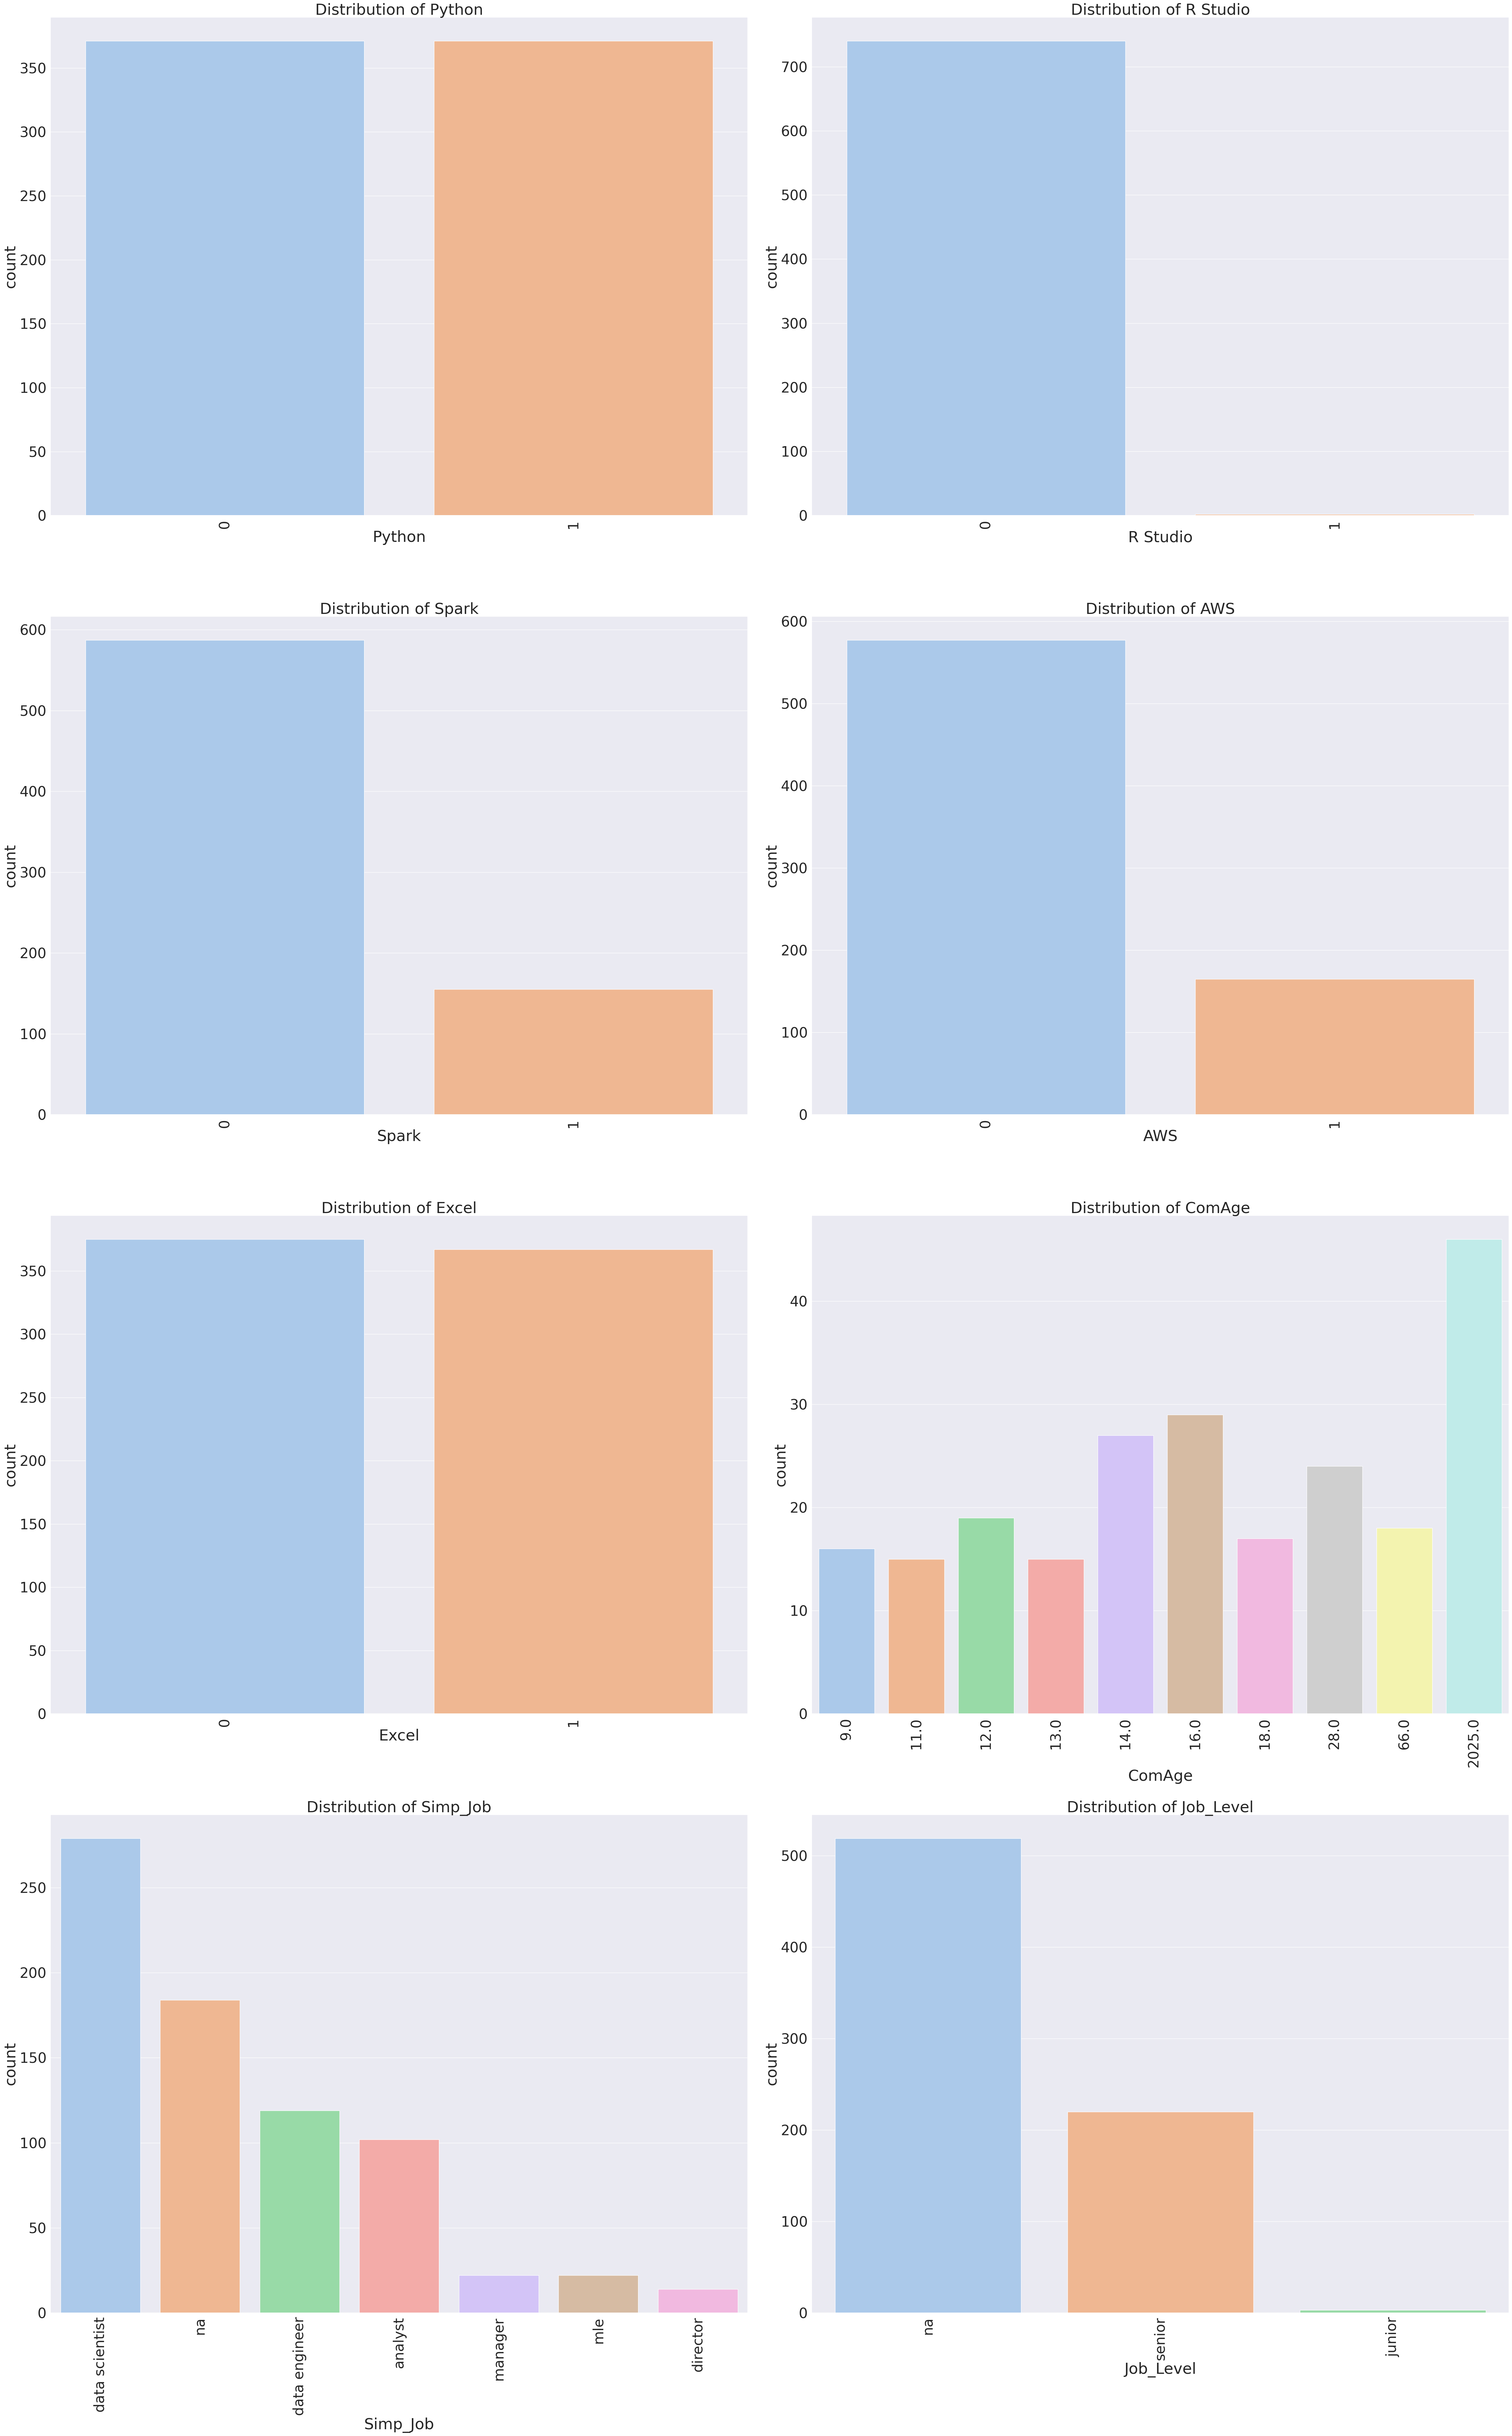

In [83]:
num_rows = len(df_cat2.columns) // 2 + len(df_cat2.columns) % 2

fig, axes = plt.subplots(num_rows, 2, figsize=(50, 20*num_rows))

axes = axes.flatten()

for i, col in enumerate(df_cat2.columns):
    # Get value counts for the current column
    cat_num2 = df_cat2[col].value_counts().head(10)
    
    # Generate a list of colors for each bar
    colors = sns.color_palette("pastel", len(cat_num2))
    
    # Plot the bar chart with custom colors
    sns.barplot(x=cat_num2.index, y=cat_num2, palette=colors, ax=axes[i])
    #sns.set(font_scale=3) 
    # Set title for the subplot
    axes[i].set_title(f"Distribution of {col}")
    
    # Rotate x-axis labels
    axes[i].tick_params(axis='x', rotation=90)
    
# Adjust layout to prevent overlap
plt.tight_layout()
sns.set(font_scale=4)
# Show the plots
plt.show()

In [29]:
# 지역별 평균 급여

# 모델

In [30]:
jobs_df.show(5)

+---+--------------------+---------------+--------------------+------+--------------------+---------------+--------------+--------------------+-------+------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+----------+------+--------+-----+---+-----+------+--------------+---------+
|_c0|           Job Title|Salary Estimate|     Job Description|Rating|        Company Name|       Location|  Headquarters|                Size|Founded| Type of ownership|            Industry|              Sector|             Revenue|         Competitors|Min_Salary|Max_Salary|Avg_Salary|Python|R Studio|Spark|AWS|Excel|ComAge|      Simp_Job|Job_Level|
+---+--------------------+---------------+--------------------+------+--------------------+---------------+--------------+--------------------+-------+------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+----------+------+--

24/12/20 16:17:25 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Job Title, Salary Estimate, Job Description, Rating, Company Name, Location, Headquarters, Size, Founded, Type of ownership, Industry, Sector, Revenue, Competitors
 Schema: _c0, Job Title, Salary Estimate, Job Description, Rating, Company Name, Location, Headquarters, Size, Founded, Type of ownership, Industry, Sector, Revenue, Competitors
Expected: _c0 but found: 
CSV file: file:///home/lab15/src/data/glassdoor_jobs.csv


In [31]:
from pyspark.sql.functions import col,sum,isnan, when

null_counts = jobs_df.select(
    [
        sum(when(col(c).isNull() | isnan(c), 1).otherwise(0)).alias(c) for c in jobs_df.columns
    ]

)
null_counts.show()

24/12/20 16:17:26 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Job Title, Salary Estimate, Job Description, Rating, Company Name, Location, Headquarters, Size, Founded, Type of ownership, Industry, Sector, Revenue, Competitors
 Schema: _c0, Job Title, Salary Estimate, Job Description, Rating, Company Name, Location, Headquarters, Size, Founded, Type of ownership, Industry, Sector, Revenue, Competitors
Expected: _c0 but found: 
CSV file: file:///home/lab15/src/data/glassdoor_jobs.csv


+---+---------+---------------+---------------+------+------------+--------+------------+----+-------+-----------------+--------+------+-------+-----------+----------+----------+----------+------+--------+-----+---+-----+------+--------+---------+
|_c0|Job Title|Salary Estimate|Job Description|Rating|Company Name|Location|Headquarters|Size|Founded|Type of ownership|Industry|Sector|Revenue|Competitors|Min_Salary|Max_Salary|Avg_Salary|Python|R Studio|Spark|AWS|Excel|ComAge|Simp_Job|Job_Level|
+---+---------+---------------+---------------+------+------------+--------+------------+----+-------+-----------------+--------+------+-------+-----------+----------+----------+----------+------+--------+-----+---+-----+------+--------+---------+
|  0|        0|              0|              0|    38|          47|      53|          54|  57|     71|               57|      60|    61|     65|         65|         0|         0|         0|     0|       0|    0|  0|    0|    71|       0|        0|
+---+---

## feature selection

In [47]:
model_data = jobs_df.select('Avg_Salary','Location','Job_Level','Min_Salary', 'Max_Salary', 'Python', 'R Studio', 'Spark','AWS', 'Excel', 'ComAge')

In [48]:
model_data.show(5)

+----------+---------------+---------+----------+----------+------+--------+-----+---+-----+------+
|Avg_Salary|       Location|Job_Level|Min_Salary|Max_Salary|Python|R Studio|Spark|AWS|Excel|ComAge|
+----------+---------------+---------+----------+----------+------+--------+-----+---+-----+------+
|      72.0|Albuquerque, NM|       na|        53|        91|     1|       0|    0|  0|    1|    51|
|      87.5|  Linthicum, MD|       na|        63|       112|     1|       0|    0|  0|    0|    40|
|      85.0| Clearwater, FL|       na|        80|        90|     1|       0|    1|  0|    1|    14|
|      76.5|   Richland, WA|       na|        56|        97|     1|       0|    0|  0|    0|    59|
|     114.5|   New York, NY|       na|        86|       143|     1|       0|    0|  0|    1|    26|
+----------+---------------+---------+----------+----------+------+--------+-----+---+-----+------+
only showing top 5 rows



In [49]:
model_data.printSchema()

root
 |-- Avg_Salary: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Job_Level: string (nullable = true)
 |-- Min_Salary: string (nullable = true)
 |-- Max_Salary: string (nullable = true)
 |-- Python: integer (nullable = false)
 |-- R Studio: integer (nullable = false)
 |-- Spark: integer (nullable = false)
 |-- AWS: integer (nullable = false)
 |-- Excel: integer (nullable = false)
 |-- ComAge: integer (nullable = true)



In [50]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

numeric_col = ['Avg_Salary','Min_Salary', 'Max_Salary', 'Python', 'R Studio', 'Spark','AWS', 'Excel', 'ComAge']
string_col = ['Location','Job_Level']

## encoding

In [51]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

indexer = StringIndexer(inputCol='Avg_Salary', outputCol='Avg_Sal', handleInvalid='skip')
model_data = indexer.fit(model_data).transform(model_data)

indexer = StringIndexer(inputCol='Location', outputCol='Local', handleInvalid='skip')
model_data = indexer.fit(model_data).transform(model_data)

indexer = StringIndexer(inputCol='Job_Level', outputCol='Level', handleInvalid='skip')
model_data = indexer.fit(model_data).transform(model_data)

indexer = StringIndexer(inputCol='Min_Salary', outputCol='Min_Sal', handleInvalid='skip')
model_data = indexer.fit(model_data).transform(model_data)

indexer = StringIndexer(inputCol='Max_Salary', outputCol='Max_Sal', handleInvalid='skip')
model_data = indexer.fit(model_data).transform(model_data)

In [52]:
model_data = model_data.fillna(0)

## feature vector

In [53]:
#target 을 제외한 학습을 위한 피처를 "features" 라는 이름으로 어셈블한다.

assembler = VectorAssembler(inputCols=['Local','Level','Min_Sal', 'Max_Sal', 'Python', 'R Studio', 'Spark','AWS', 'Excel', 'ComAge'],
                            outputCol="features") #handleInvalid="skip"
model_data = assembler.transform(model_data)
model_data

DataFrame[Avg_Salary: double, Location: string, Job_Level: string, Min_Salary: string, Max_Salary: string, Python: int, R Studio: int, Spark: int, AWS: int, Excel: int, ComAge: int, Avg_Sal: double, Local: double, Level: double, Min_Sal: double, Max_Sal: double, features: vector]

In [54]:
model_data.printSchema()

root
 |-- Avg_Salary: double (nullable = false)
 |-- Location: string (nullable = true)
 |-- Job_Level: string (nullable = true)
 |-- Min_Salary: string (nullable = true)
 |-- Max_Salary: string (nullable = true)
 |-- Python: integer (nullable = false)
 |-- R Studio: integer (nullable = false)
 |-- Spark: integer (nullable = false)
 |-- AWS: integer (nullable = false)
 |-- Excel: integer (nullable = false)
 |-- ComAge: integer (nullable = true)
 |-- Avg_Sal: double (nullable = false)
 |-- Local: double (nullable = false)
 |-- Level: double (nullable = false)
 |-- Min_Sal: double (nullable = false)
 |-- Max_Sal: double (nullable = false)
 |-- features: vector (nullable = true)



In [55]:
# 지도 학습, 분류 모델 학습 시키기 위한 데이터
model_data.select('Avg_Sal','features').show(5)

+-------+--------------------+
|Avg_Sal|            features|
+-------+--------------------+
|  164.0|[49.0,0.0,57.0,30...|
|    0.0|(10,[0,2,3,4,9],[...|
|    6.0|[36.0,0.0,2.0,79....|
|   17.0|(10,[0,2,3,4,9],[...|
|   13.0|(10,[2,3,4,8,9],[...|
+-------+--------------------+
only showing top 5 rows



## dataset 분할

In [56]:
train_data, test_data = model_data.randomSplit([0.8, 0.2], seed = 42 ) #리턴값목록, 목록2

In [57]:
train_data.show(5), test_data.show(5)

+----------+----------------+---------+----------+----------+------+--------+-----+---+-----+------+-------+-----+-----+-------+-------+--------------------+
|Avg_Salary|        Location|Job_Level|Min_Salary|Max_Salary|Python|R Studio|Spark|AWS|Excel|ComAge|Avg_Sal|Local|Level|Min_Sal|Max_Sal|            features|
+----------+----------------+---------+----------+----------+------+--------+-----+---+-----+------+-------+-----+-----+-------+-------+--------------------+
|      13.5|   Nashville, TN|   senior|        10|        17|     0|       0|    0|  0|    1|    24|  130.0| 25.0|  1.0|   88.0|  104.0|[25.0,1.0,88.0,10...|
|      13.5|   Nashville, TN|   senior|        10|        17|     0|       0|    0|  0|    1|    24|  130.0| 25.0|  1.0|   88.0|  104.0|[25.0,1.0,88.0,10...|
|      20.0| New Orleans, LA|       na|        15|        25|     0|       0|    0|  0|    0|    94|  201.0|109.0|  0.0|   99.0|   55.0|(10,[0,2,3,9],[10...|
|      20.5|West Reading, PA|       na|        17|  

(None, None)

# 분류 예측 model 생성 - 선형 회귀

분류모델 : 라벨(타겟), 피쳐

In [58]:
from pyspark.ml.classification import LogisticRegression

In [76]:
from pyspark.ml.regression import LinearRegression

# 선형 회귀 모델 생성
lr = LinearRegression(featuresCol="features", labelCol="Avg_Sal")

# 모델 학습
lr_model = lr.fit(train_data)

# 예측
predictions = lr_model.transform(test_data)

# 결과 확인
predictions.select("Avg_Sal", "prediction").show()

24/12/20 16:44:46 WARN Instrumentation: [3762dbcd] regParam is zero, which might cause numerical instability and overfitting.
24/12/20 16:44:47 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/12/20 16:44:47 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


+-------+------------------+
|Avg_Sal|        prediction|
+-------+------------------+
|  192.0| 158.1458507313219|
|   65.0| 93.74141949578406|
|   65.0| 93.74141949578406|
|  105.0|110.38410191645346|
|   26.0| 64.38549003919915|
|  106.0|110.79684939745081|
|  208.0| 157.3895228738139|
|  107.0| 99.03691600364596|
|   66.0| 63.59339585220296|
|   66.0| 63.59339585220296|
|  109.0| 84.80461465097541|
|  109.0| 222.8238903080212|
|  110.0|  89.2135782962384|
|   67.0| 72.95914863373957|
|   27.0| 73.21276571776914|
|   28.0| 63.71908950516645|
|  212.0|119.46323992079921|
|   29.0| 66.11036724966881|
|  159.0| 84.78628448433238|
|   69.0|  42.5402334645521|
+-------+------------------+
only showing top 20 rows



#로지스틱 회귀 모델 생성
lr = LogisticRegression( featuresCol="features", labelCol='Avg_Sal')

#모델 학습 80%
lr_model = lr.fit(train_data)

# 테스트
predictions = lr_model.transform(test_data)
predictions.show(5)

In [77]:
predictions.select('features', 'Avg_Sal', 'prediction').tail(5)

[Row(features=SparseVector(10, {0: 2.0, 2: 96.0, 3: 114.0, 9: 16.0}), Avg_Sal=141.0, prediction=128.48030842551003),
 Row(features=DenseVector([15.0, 1.0, 97.0, 73.0, 0.0, 0.0, 0.0, 1.0, 1.0, 17.0]), Avg_Sal=100.0, prediction=112.83614699013735),
 Row(features=DenseVector([2.0, 0.0, 73.0, 91.0, 1.0, 0.0, 1.0, 0.0, 0.0, 17.0]), Avg_Sal=102.0, prediction=109.86448119446764),
 Row(features=DenseVector([2.0, 0.0, 73.0, 91.0, 1.0, 0.0, 1.0, 0.0, 0.0, 17.0]), Avg_Sal=102.0, prediction=109.86448119446764),
 Row(features=DenseVector([80.0, 1.0, 100.0, 74.0, 1.0, 0.0, 0.0, 0.0, 1.0, 66.0]), Avg_Sal=146.0, prediction=123.08248538168297)]

In [78]:
# 예측 결과 저장
predictions.select( 'Avg_Sal', 'prediction','Min_Sal','Max_Sal') \
.withColumnRenamed('prediction', 'Pred_Sal') \
.coalesce(1) \
.write.csv('data/pred_sal', header=True)

In [79]:
df = pd.read_csv('data/pred_sal/part-00000-f93b3ced-1f77-4ac3-84b7-8f395f7c2ee5-c000.csv')
df.head()

,Avg_Sal,Pred_Sal,Min_Sal,Max_Sal
0,192.0,158.145851,99.0,131.0
1,65.0,93.741419,63.0,55.0
2,65.0,93.741419,63.0,55.0
3,105.0,110.384102,79.0,92.0
4,26.0,64.385490,27.0,41.0
